In [6]:
import pandas as pd
import json
from evaluation_utils import read_global_results, ssl_method_to_category, unpivot_ssl_model, unpivot_baseline_model, read_processed_shards
from constants import RESULTS_ROOT, PRELIMINARY_DIR, MODE_1_PROCESSED_DIR, MODE_2_3_MARG_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, ENCODER_COLORS, SINGLE_ENCODER_MODELS, \
                        GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, MODE_1_LEARNING_CURVES_DIR, model_abbreviations, MODE_2_3_PROCESSED_DIR, MODE_2_3_MARG_2_PROCESSED_DIR
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
import itertools
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib.colors import ListedColormap
from itertools import zip_longest
from os.path import join
from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from matplotlib.patches import Polygon
from sklearn.metrics import silhouette_score
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from celluloid import Camera
from IPython.display import HTML
import matplotlib.animation as animation


In [2]:
df = read_processed_shards(MODE_2_3_MARG_2_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
concatenating


In [3]:
# SSL results
df_ssl = unpivot_ssl_model(df=df, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES,  include_graph_params=True)
df_baseline = unpivot_baseline_model(df=df, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES, include_graph_params=True)

# Cleanup
df_ssl['marginal_param'] = df_ssl['marginal_param'].apply(tuple)

In [42]:
def plot_surface_3d(df_marg, marg1, marg2, bins=15):
    df_plot = df_marg.copy()
    df_plot[marg1] = pd.cut(df_plot[marg1], bins=bins, duplicates='drop').apply(lambda x: x.mid)
    df_plot[marg2] = pd.cut(df_plot[marg2], bins=bins, duplicates='drop').apply(lambda x: x.mid)
    df_grouped = df_plot.groupby(['Encoder', 'Training_scheme', marg1, marg2]).mean().reset_index()

    fig = go.Figure()


    for n, g in df_grouped.groupby(['Encoder', 'Training_scheme']):
        print(n)
        # df_pivot = g.pivot(index=marg2, columns=marg1, values="test_rocauc_ovr")

        # z = df_pivot.values
        # y = df_pivot.index.values
        # x = df_pivot.columns.values

        fig.add_trace(go.Mesh3d(x=g[marg1],
                   y=g[marg2],
                   z=g['test_rocauc_ovr'],
                   opacity=0.2,
                   color=ENCODER_COLORS[n[0]]
                  ))


        # fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
    fig.update_layout(title=f'{marg1} & {marg2}', 
                        scene = dict(
                        xaxis_title=marg1,
                        yaxis_title=marg2,
                        zaxis_title='ROC AUC'))
    fig.show()

In [4]:
def plot_marginalization(df_marg, marg1, marg2, bins=5, ylim=(65,100), yticks=[75, 80, 85, 90, 95, 100]):
    fig = plt.figure()
    camera = Camera(fig)
    sns.set_style("white")
    df_marg_plot = df_marg.copy()
    df_marg_plot = df_marg_plot.sort_values(by=['Encoder', 'Training_scheme'])

    df_marg_plot[marg1] = pd.cut(df_marg_plot[marg1], bins=bins, duplicates='drop').apply(lambda x: x.mid)
    df_marg_plot[marg2] = pd.cut(df_marg_plot[marg2], bins=bins, duplicates='drop').apply(lambda x: x.mid)
    with sns.axes_style("darkgrid"):
        for n,g in df_marg_plot.groupby(marg2):
            ax = sns.lineplot(data=g, x=marg1, y='test_rocauc_ovr', hue=df_marg_plot['Encoder'], style='Training_scheme',
                    markers=None, dashes=True, errorbar=None, palette=ENCODER_COLORS, legend=False)
            ax.set_ylim(ylim[0], ylim[1])
            camera.snap()
        #ax.set_ylim(ylim[0], ylim[1])
    
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1.25, 1.02))
    #ax.set_title(method)
    return camera.animate()


In [8]:
def plot_marginalization_2(df_marg, marg1, marg2, bins=5, ylim=(65,100), yticks=[75, 80, 85, 90, 95, 100]):
    fig, ax = plt.subplots(figsize = (10, 8))
    sns.set_style("white")
    df_marg_plot = df_marg.copy()
    df_marg_plot[marg1] = pd.cut(df_marg_plot[marg1], bins=bins, duplicates='drop').apply(lambda x: x.mid)
    df_marg_plot[marg2] = pd.cut(df_marg_plot[marg2], bins=bins, duplicates='drop').apply(lambda x: x.mid)
    df_marg_plot = df_marg_plot.sort_values(by=[marg2, 'Encoder', 'Training_scheme'])

    def update(m2):
        ax.cla()
        df_marg_1 = df_marg_plot[df_marg_plot[marg2] == m2]
        sns.lineplot(data=df_marg_1, x=marg1, y='test_rocauc_ovr', hue=df_marg_plot['Encoder'], style='Training_scheme',
                    markers=None, dashes=True, errorbar=None, palette=ENCODER_COLORS, legend=True)
        ax.set_title(f'{marg2}:m2', fontsize = 20)
        ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), prop = {'size': 12})
        #ax.set_xlabel('size', fontsize = 16)
        #ax.set_ylabel('score', fontsize = 16)
        #ax.set_xlim(0, 10)
        #ax.set_xlim(0, 10)
        #ax.set_xticks(np.linspace(0, 10, 6))
        #ax.set_yticks(np.linspace(0, 10, 6))
        #ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

    ani = animation.FuncAnimation(fig, update, frames = df_marg_plot[marg2].unique())
    ani.save('test.mp4', dpi=200, fps=1)

    plt.show()

MovieWriter stderr:
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '2000x1600', '-pix_fmt', 'rgba', '-r', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'test.mp4']' returned non-zero exit status 127.

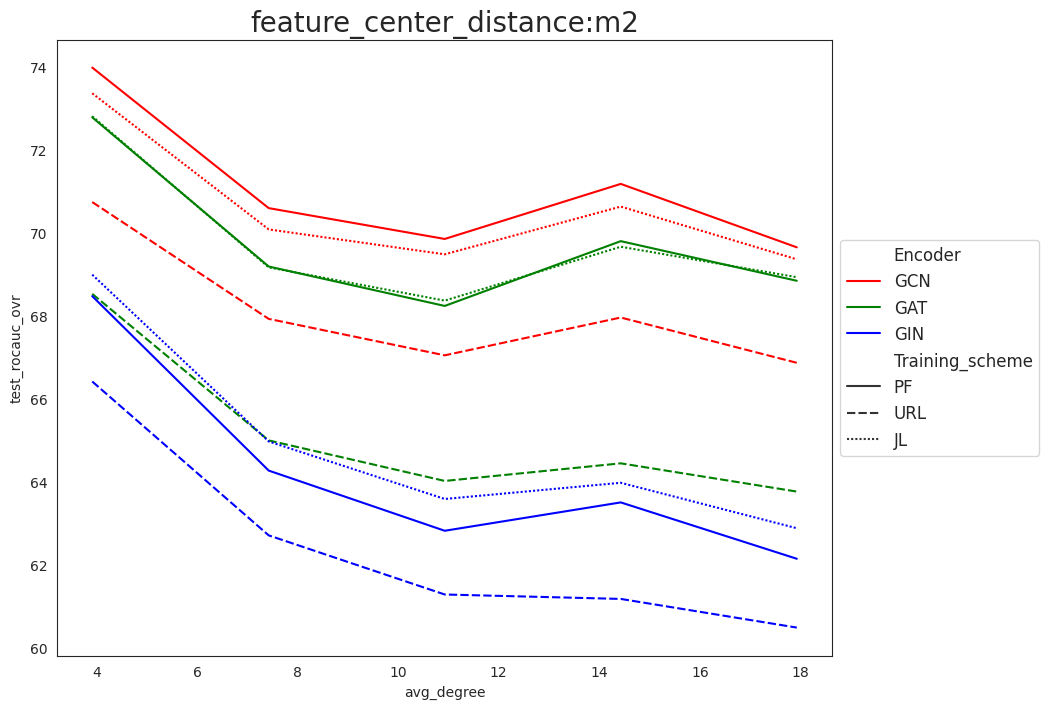

In [9]:
for n, g in df_ssl.groupby("marginal_param"):
    plot_marginalization_2(g, n[0], n[1], ylim=(50,90))
    break